In [2]:
# データ読み込み
import pandas as pd

df = pd.read_csv("data/processed/employee_with_features.csv")

In [3]:
from sklearn.model_selection import train_test_split
import pickle

# 説明変数・目的変数（attrition_flagがターゲット）
# 「ACTIVE」「TERMINATED」は文字列なので、そのままだとエラーになるため0/1の数値に変換する。
# STATUSが"TERMINATED"なら1（True）、それ以外は0（False）とする。
df["target"] = (df["STATUS"]  == "TERMINATED").astype(int)

# 学習に不要・リークの可能性ある列削除
drop_col = [
    "STATUS", "terminationdate_key", "termreason_desc", "termtype_desc",
    "EmployeeID", "gender_full", "orighiredate_key", "birthdate_key",
    "recorddate_key", "attrition_flag"
]

#　説明変数と目的変数を作成
X = df.drop(columns=drop_col + ["target"])
y = df["target"]

# データ分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 前処理とモデル読み込み
with open("models/preprocess.pkl", "rb") as f:
    preprocess = pickle.load(f)
print("前処理を読み込みました！（models/preprocess.pkl）")

with open("models/01_DecisionTree.pkl", "rb") as f:
    model = pickle.load(f)
print("学習済みモデルを読み込みました！（models/01_DecisionTree.pkl）")


前処理を読み込みました！（models/preprocess.pkl）
学習済みモデルを読み込みました！（models/01_DecisionTree.pkl）


In [4]:
#前処理をテストデータに適用
X_test_preprocessed = preprocess.transform(X_test)

#予測
y_pred = model.named_steps["clf"].predict(X_test_preprocessed)
y_prob = model.named_steps["clf"].predict_proba(X_test_preprocessed)[:, 1]

In [5]:
# 基本指標
from sklearn.metrics import accuracy_score,roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9624408418084786
AUC: 0.8944078876090501


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

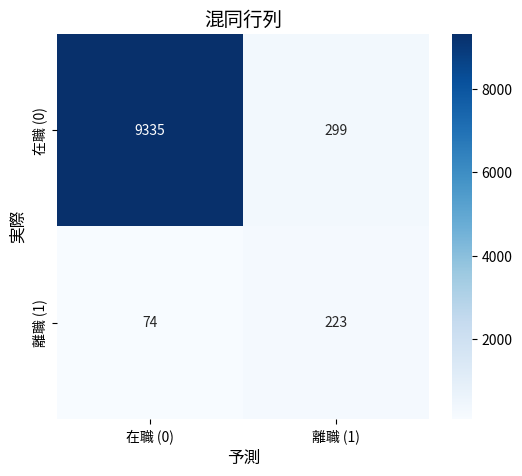

In [25]:
# 予測と実際の在職者・退職者混同行列作成

cm = confusion_matrix(y_test, y_pred)
labels = ["在職 (0)", "離職 (1)"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("予測", fontsize=12)
plt.ylabel("実際", fontsize=12)
plt.title("混同行列", fontsize=14)

plt.savefig("reports/confusion_matrix.png", dpi=300)

plt.show()


##### 適合率（precision）
0(在職者)：在職と予測したうち、99%正解(1%は誤報)  
1(離職者): 離職と予測したうち、43%正解(57％は誤報)

##### 再現率（recall）
0(在職者):在職者(9634人)のうち、97％は見逃さず予測できた  
1(離職者):離職者(297人)のうち、75%は見逃さず予測できた  

##### F1スコア（precisionとrecallのバランス）
0(在職者):0.98 離職者の97%を拾えており、誤報も1%  
1(離職者):0.54 離職者75%拾えており、誤報も一定程度抑えられている。

In [8]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# 結果確認
display(report_df)


,precision,recall,f1-score,support
0,0.992135,0.968964,0.980413,9634.000000
1,0.427203,0.750842,0.544567,297.000000
accuracy,0.962441,0.962441,0.962441,0.962441
macro avg,0.709669,0.859903,0.762490,9931.000000
weighted avg,0.975240,0.962441,0.967378,9931.000000


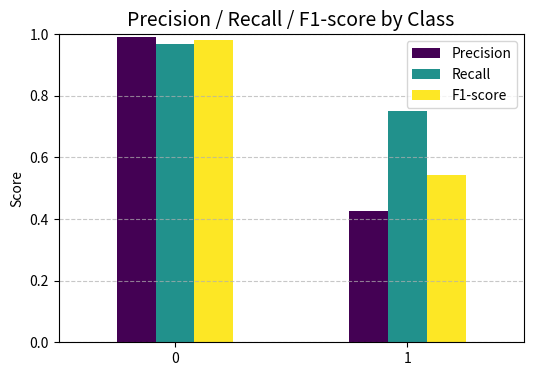

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# レポートをDataFrame化
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# "0"と"1"のクラスだけ抜き出す
df_cls = df_report.loc[["0", "1"], ["precision", "recall", "f1-score"]]

# 可視化
df_cls.plot(kind="bar", figsize=(6,4), colormap="viridis", rot=0)
plt.title("Precision / Recall / F1-score by Class", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(["Precision", "Recall", "F1-score"])
plt.grid(axis="y", linestyle="--", alpha=0.7)


plt.savefig("reports/precision_recall_F1-score.png", dpi=300)

plt.show()



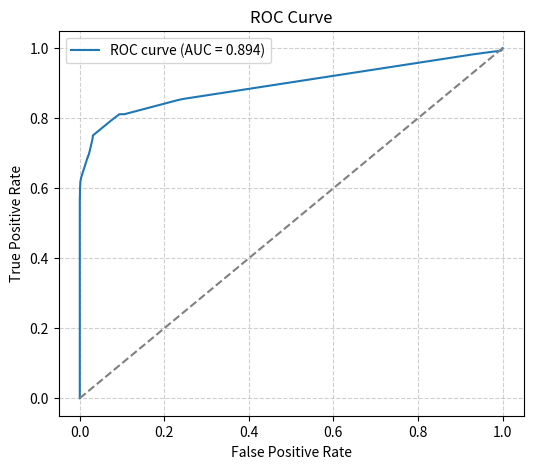

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.savefig("reports/roc_curve.png", dpi=300)



plt.show()

#左上に急カーブしており、誤報を少なくしながら多くの離職者を拾えている
#在職・離職を約89%の確率で正しく識別できる

In [ ]:
# 決定木の特徴重要度(木の分岐で、その特徴がどれだけGini不純度を減らしたか（情報利得）⇒構造的な影響度を見る

importances = model.named_steps["clf"].feature_importances_

# 特徴名（前処理後）
feature_names = model.named_steps["preprocess"].get_feature_names_out()

# DataFrame化してソート
import pandas as pd
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

display(importance_df.head(10))


# ・各ノードで、その特徴を使った分岐による「Gini不純度の減少量（情報利得）」を計算
# ・その合計を全特徴の総情報利得で割って正規化した値が重要度となる

,Feature,Importance
0,scale__age,0.661623
114,cat__gender_short_F,0.095645
1,scale__length_of_service,0.045226
16,cat__city_name_Fort Nelson,0.039250
2,scale__relative_service,0.032979
5,num__age_group_encoded,0.028440
76,cat__job_title_Cashier,0.027022
18,cat__city_name_Grand Forks,0.024625
44,cat__city_name_White Rock,0.020465
115,cat__gender_short_M,0.013037


,feature,importance_mean,importance_std
0,age,0.127459,0.003317
13,age_group_encoded,0.048404,0.001070
6,gender_short,0.024147,0.001447
1,length_of_service,0.012184,0.000425
2,city_name,0.003303,0.000622
3,department_name,0.000000,0.000000
9,age_group,0.000000,0.000000
5,store_name,0.000000,0.000000
8,BUSINESS_UNIT,0.000000,0.000000
7,STATUS_YEAR,0.000000,0.000000


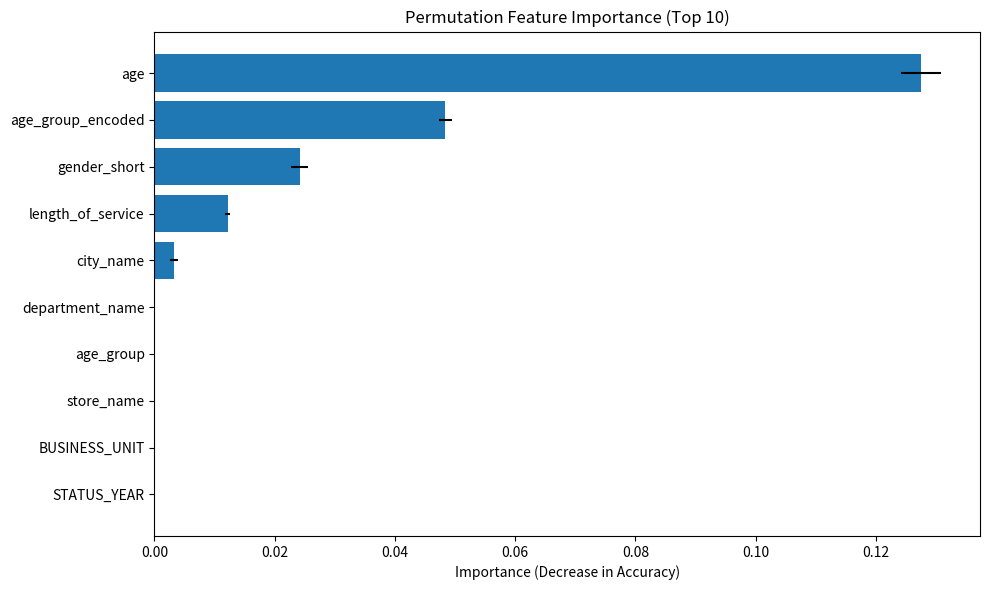

In [28]:
# PFI（ある特徴をグチャグチャにしたら、どれだけ予測性能が落ちるか）⇒実際の予測精度への影響度を見る。



from sklearn.inspection import permutation_importance

# Permutation Importance の計算
result = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42
)

# 結果をDataFrameにまとめ
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

# 上位表示
display(importance_df.head(10))


import matplotlib.pyplot as plt

# 上位10個だけを表示
top_n = 10
top_features = importance_df.head(top_n)




plt.figure(figsize=(10, 6))
plt.barh(top_features["feature"], top_features["importance_mean"], xerr=top_features["importance_std"])
plt.gca().invert_yaxis()  # 上位を上に表示
plt.xlabel("Importance (Decrease in Accuracy)")
plt.title(f"Permutation Feature Importance (Top {top_n})")
plt.tight_layout()

plt.savefig("reports/pfi.png", dpi=300)


plt.show()


#黒い線の意味（エラーバー）#「この特徴の重要度は平均で○○だけど、繰り返しによって ±○○くらいの誤差がある」


# 特徴量重要度（Permutation Importance）：
# 特徴量「年齢（age）」をシャッフルすると、モデルの予測精度が約12%低下。
# これは「年齢」が離職予測において最も重要な要因であることを示す。
# 次いで「年代カテゴリ（age_group_encoded）」と「性別（gender_short）」

「年齢（age）」が両指標で最も高いことから、
離職傾向の説明において「年齢」が安定して強い影響を持つことが確認された。

「性別（gender_short）」や「年代カテゴリ（age_group_encoded）」も上位に入り、
性別や年代による傾向の違いもモデルが捉えている可能性がある。

一方で、決定木では勤務地など一部のカテゴリが上位に出る傾向があるが、PFIではそれらの特徴を壊しても精度がほとんど下がらず、実際の予測には大きく寄与していないことがわかった。